In [1]:
import pandas as pd
from river import datasets
from river import metrics
from river import stream
from river import compose
from river import linear_model
from river import preprocessing
from river import optim
from river import tree
import river
from river import evaluate
import csv
import json 
import numpy as np


# data exploration

In [10]:
import pandas as pd
from river import datasets

# Load the MovieLens 100K dataset
dataset = datasets.MovieLens100K()

# Convert the dataset to a pandas DataFrame
data = []

# The MovieLens100K dataset is iterable, so we can iterate over it
for x, y in dataset:
    data.append(x)

# Convert the list to a pandas DataFrame
df = pd.DataFrame(data)

# Show the first few rows of the DataFrame
print(df.head())

# Convert the timestamp to a datetime format for easier analysis
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ns')

# Check if the timestamps are in ascending order
is_ascending = df['timestamp'].is_monotonic_increasing

# Output the result
print(f"Are the timestamps in ascending order? {is_ascending}")


  user item           timestamp                            title  \
0  259  255  874731910000000000  My Best Friend's Wedding (1997)   
1  259  286  874731927000000000      English Patient, The (1996)   
2  259  298  874731954000000000                  Face/Off (1997)   
3  259  185  874731981000000000                    Psycho (1960)   
4  259  173  874732043000000000       Princess Bride, The (1987)   

         release_date                              genres   age gender  \
0  866764800000000000                     comedy, romance  21.0      M   
1  848016000000000000                 drama, romance, war  21.0      M   
2  867369600000000000            action, sci_fi, thriller  21.0      M   
3 -315619200000000000           horror, romance, thriller  21.0      M   
4  536457600000000000  action, adventure, comedy, romance  21.0      M   

  occupation zip_code  
0    student    48823  
1    student    48823  
2    student    48823  
3    student    48823  
4    student    48823  
Ar

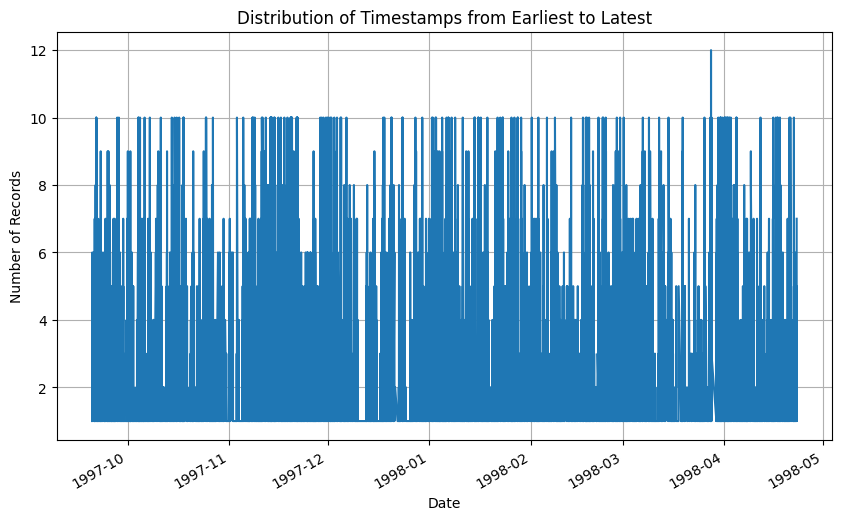

In [13]:
import matplotlib.pyplot as plt

# Group the timestamps by day, week, or month depending on your needs
timestamp_distribution = df['timestamp'].value_counts().sort_index()

# Plot the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
timestamp_distribution.plot(kind='line')
plt.xlabel('Date')
plt.ylabel('Number of Records')
plt.title('Distribution of Timestamps from Earliest to Latest')
plt.grid(True)
plt.show()

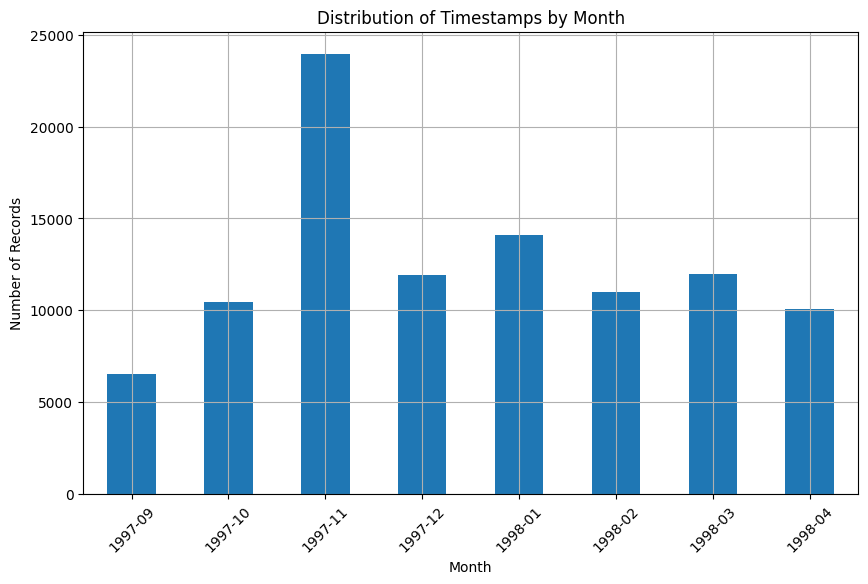

In [14]:
# Group the timestamps by month for the distribution analysis
df['month'] = df['timestamp'].dt.to_period('M')

# Get the count of records for each month
monthly_distribution = df['month'].value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(10, 6))
monthly_distribution.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Number of Records')
plt.title('Distribution of Timestamps by Month')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

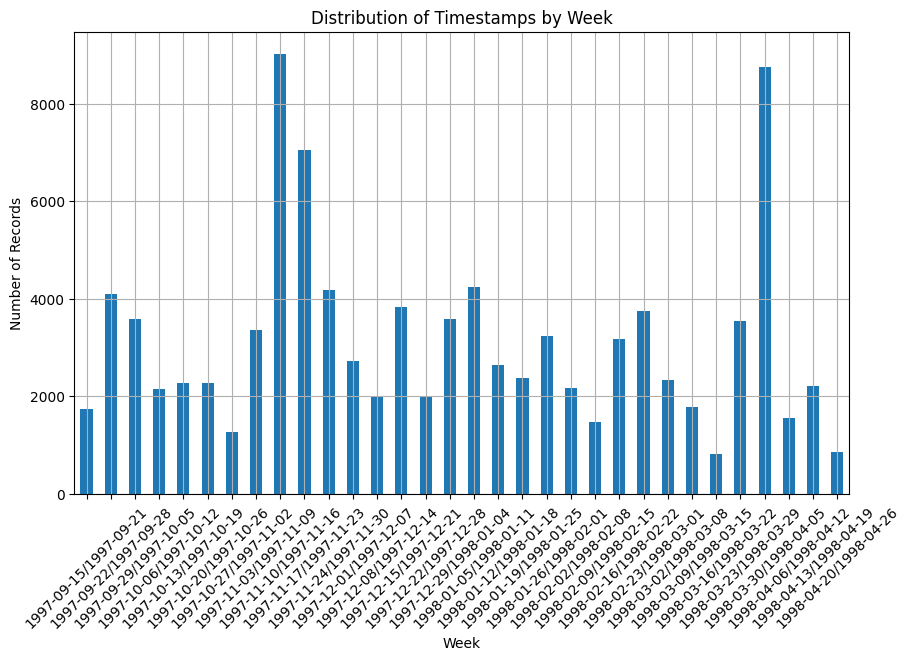

In [15]:
# Group the timestamps by week for the distribution analysis
df['week'] = df['timestamp'].dt.to_period('W')

# Get the count of records for each week
weekly_distribution = df['week'].value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(10, 6))
weekly_distribution.plot(kind='bar')
plt.xlabel('Week')
plt.ylabel('Number of Records')
plt.title('Distribution of Timestamps by Week')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# use hoeffding tree and hoeffding adaptive tree

- different predicting algorithms: hoeffding tree and hoeffding adaptive tree
- different age groups: 2 groups and 4 groups
- classify using age and then analyze results using age groups
- 

# check dataset

In [2]:
from river import datasets

# Load the dataset
dataset = datasets.MovieLens100K()

# Inspect the first few examples
for i, (x, y) in enumerate(dataset):
    print(f"Example {i+1}")
    print("Features:", x)
    print("Rating:", y)
    print()  # Blank line for readability
    if i >= 4:  # Stop after 5 examples
        break


Example 1
Features: {'user': '259', 'item': '255', 'timestamp': 874731910000000000, 'title': "My Best Friend's Wedding (1997)", 'release_date': 866764800000000000, 'genres': 'comedy, romance', 'age': 21.0, 'gender': 'M', 'occupation': 'student', 'zip_code': '48823'}
Rating: 4.0

Example 2
Features: {'user': '259', 'item': '286', 'timestamp': 874731927000000000, 'title': 'English Patient, The (1996)', 'release_date': 848016000000000000, 'genres': 'drama, romance, war', 'age': 21.0, 'gender': 'M', 'occupation': 'student', 'zip_code': '48823'}
Rating: 4.0

Example 3
Features: {'user': '259', 'item': '298', 'timestamp': 874731954000000000, 'title': 'Face/Off (1997)', 'release_date': 867369600000000000, 'genres': 'action, sci_fi, thriller', 'age': 21.0, 'gender': 'M', 'occupation': 'student', 'zip_code': '48823'}
Rating: 4.0

Example 4
Features: {'user': '259', 'item': '185', 'timestamp': 874731981000000000, 'title': 'Psycho (1960)', 'release_date': -315619200000000000, 'genres': 'horror, r

# dataset is sorted by timestamp

In [3]:
# check whether the timestamp in the dataset is sorted
import river


# Load a stream of data
dataset = datasets.MovieLens100K()

previous_timestamp = None
is_sorted = True

# Iterate over the dataset
for x, y in dataset:
    current_timestamp = x['timestamp']  # Replace 'timestamp' with the actual column name
    if previous_timestamp is not None:
        if current_timestamp < previous_timestamp:
            is_sorted = False
            break
    previous_timestamp = current_timestamp

if is_sorted:
    print("The dataset is sorted by timestamp.")
else:
    print("The dataset is NOT sorted by timestamp.")


The dataset is sorted by timestamp.


# hoeffding tree / adaptive tree classifier (detect concept drift / no detection)

In [18]:
import csv
import json
from river import tree, metrics, datasets

# Initialize the classifier
# model = tree.HoeffdingAdaptiveTreeClassifier()
model = tree.HoeffdingAdaptiveTreeClassifier()

# Initialize classification metrics
accuracy = metrics.Accuracy()
precision = metrics.Precision()
recall = metrics.Recall()
f1 = metrics.F1()

# Load a stream of data
dataset = datasets.MovieLens100K()



headers = ["user", "item", "timestamp", "title", "release_date", "genres", "age", "age_2groups","age_4groups","gender", "occupation","zip_code","rating","prediction","datetime","rating_binary","prediction_binary","diff","diff_binary_correctness"]

# Open the CSV file for writing and write the header
with open("result_hoeffding_adaptive_classifier.csv", "w", newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=headers)
    writer.writeheader()

    rows = []
    # Process the first 1000 examples for demonstration
    for x, y in dataset:
        
        # Get the prediction from the model
        pred = model.predict_one(x)

        # Update the model regardless of the prediction being None
        model.learn_one(x, y)

        # Add the actual rating and the prediction to the dictionary
        x['rating'] = y
        x['prediction'] = pred
        preds = pred if pred is not None else 0
        
        x["rating_binary"] = int(y >= 4)
        x["prediction_binary"] = int(pred >= 4) if pred is not None else None
        x["diff"] = abs(y - preds)
        x["diff_binary_correctness"] = int(bool(abs(y - preds) <= 1))
        x["datetime"] = pd.to_datetime(x['timestamp'], unit='ns').strftime('%Y-%m-%d %H:%M:%S')

        
        if x["age"] <= 30:
            x["age_2groups"] = "7-30"
        else:
            x["age_2groups"] = "31-73"
        
        if x["age"] <= 24:
            x["age_4groups"] = "7-24"
        elif x["age"] <= 30:
            x["age_4groups"] = "25-30"
        elif x["age"] <= 40:
            x["age_4groups"] = "31-40"
        else:
            x["age_4groups"] = "41-73"
        writer.writerow(x)
        # Check if the prediction is valid before updating metrics
        if pred is None:
            print('Prediction is None, skipping metric update.')
            continue

        # Update classification metrics
        accuracy.update(y, pred)
        precision.update(y, pred)
        recall.update(y, pred)
        f1.update(y, pred)

# Output the final results for the classification task
print(f"Accuracy: {accuracy.get():.4f}")
print(f"Precision: {precision.get():.4f}")
print(f"Recall: {recall.get():.4f}")
print(f"F1 Score: {f1.get():.4f}")




Prediction is None, skipping metric update.
Accuracy: 0.3294
Precision: 0.1524
Recall: 0.0732
F1 Score: 0.0989


,user,item,timestamp,title,release_date,genres,age,age_2groups,gender,occupation,zip_code,rating,prediction,datetime,age_4groups,rating_binary,prediction_binary,diff,diff_binary_correctness


# preprocess time stamp

In [26]:

df = pd.read_csv('result_hoeffding_classifier.csv', dtype={"zip_code": str})
df.head()


,Unnamed: 0,user,item,timestamp,title,release_date,genres,age,gender,occupation,zip_code,rating,prediction,datetime,age_group,rating_binary,prediction_binary
0,0,259,255,874731910000000000,My Best Friend's Wedding (1997),866764800000000000,"comedy, romance",21.0,M,student,48823,4.0,NaN,1997-09-20,7-25,1,0
1,1,259,286,874731927000000000,"English Patient, The (1996)",848016000000000000,"drama, romance, war",21.0,M,student,48823,4.0,4.0,1997-09-20,7-25,1,1
2,2,259,298,874731954000000000,Face/Off (1997),867369600000000000,"action, sci_fi, thriller",21.0,M,student,48823,4.0,4.0,1997-09-20,7-25,1,1
3,3,259,185,874731981000000000,Psycho (1960),-315619200000000000,"horror, romance, thriller",21.0,M,student,48823,4.0,4.0,1997-09-20,7-25,1,1
4,4,259,173,874732043000000000,"Princess Bride, The (1987)",536457600000000000,"action, adventure, comedy, romance",21.0,M,student,48823,4.0,4.0,1997-09-20,7-25,1,1


In [27]:

df.sort_values(by='timestamp', ascending=True, inplace=True)
df.head()


,Unnamed: 0,user,item,timestamp,title,release_date,genres,age,gender,occupation,zip_code,rating,prediction,datetime,age_group,rating_binary,prediction_binary
0,0,259,255,874731910000000000,My Best Friend's Wedding (1997),866764800000000000,"comedy, romance",21.0,M,student,48823,4.0,NaN,1997-09-20,7-25,1,0
1,1,259,286,874731927000000000,"English Patient, The (1996)",848016000000000000,"drama, romance, war",21.0,M,student,48823,4.0,4.0,1997-09-20,7-25,1,1
2,2,259,298,874731954000000000,Face/Off (1997),867369600000000000,"action, sci_fi, thriller",21.0,M,student,48823,4.0,4.0,1997-09-20,7-25,1,1
3,3,259,185,874731981000000000,Psycho (1960),-315619200000000000,"horror, romance, thriller",21.0,M,student,48823,4.0,4.0,1997-09-20,7-25,1,1
4,4,259,173,874732043000000000,"Princess Bride, The (1987)",536457600000000000,"action, adventure, comedy, romance",21.0,M,student,48823,4.0,4.0,1997-09-20,7-25,1,1


In [25]:
zipcodes = df["zip_code"].unique()
print(zipcodes)

['48823' '29646' '54901' '67401' '61801' 'M4J2K' '48197' '95064' '76201'
 '92705' '77845' '44106' '70808' '60152' '93555' '90247' '95823' '48105'
 '95123' '03869' '76059' '30068' '60115' '98103' '60402' '85711' '48322'
 '98006' '02215' '90019' '03261' '97229' '65203' '55436' '27514' '29440'
 '95032' '85281' '94533' '92626' '92064' '10522' '68503' '49512' '20685'
 '85251' '28018' 'V3N4P' '02341' '64131' '14216' '19422' '20707' '84601'
 '55414' '79070' '31211' '84116' '95403' '90210' '91919' '77841' 'V5A2B'
 '42459' '85210' '55454' 'K7L5J' '92037' '98682' '22207' '60089' '68767'
 '15213' '80525' '55106' '60008' '14211' '22030' '55409' '06365' 'T8H1N'
 '75240' '90814' '15217' '30220' '01810' '02125' '01824' '91206' '06512'
 '20854' '87544' '34105' '98121' '61820' '93402' '91711' '15203' '97302'
 '06333' '62901' '62903' '27105' '95129' '22902' '99687' '30093' '33884'
 '97232' '35802' '73132' '94115' '45810' '21218' '43017' '45439' '37411'
 '01940' '85719' '98072' '66215' '94619' '90405' '9

In [16]:
string_rows = df[df.iloc[:, 10].apply(lambda x: isinstance(x, str))]

print(len(string_rows))
print(string_rows[:1])
# # Display the filtered rows
# import ace_tools as tools
# tools.display_dataframe_to_user(name="Rows with Column 10 as String", dataframe=string_rows)


98304
   Unnamed: 0  user  item           timestamp  \
0           0   259   255  874731910000000000   

                             title        release_date           genres   age  \
0  My Best Friend's Wedding (1997)  866764800000000000  comedy, romance  21.0   

  gender occupation zip_code  rating  prediction    datetime age_group  \
0      M    student    48823     4.0         NaN  1997-09-20      7-25   

   rating_binary  prediction_binary  
0              1                  0  


In [21]:
# get other rows
other_rows = df[df.iloc[:, 10].apply(lambda x: not isinstance(x, str))]
print(len(other_rows))
print(other_rows[10:11])
columns = df.columns
print(columns[10])

1696
       Unnamed: 0  user  item           timestamp                  title  \
98314       98314   551   162  892790442000000000  On Golden Pond (1981)   

             release_date genres   age gender  occupation zip_code  rating  \
98314  347155200000000000  drama  25.0      M  programmer    55414     5.0   

       prediction    datetime age_group  rating_binary  prediction_binary  
98314         4.0  1998-04-17     26-31              1                  1  
zip_code


In [22]:
print(df.dtypes)


Unnamed: 0             int64
user                   int64
item                   int64
timestamp              int64
title                 object
release_date           int64
genres                object
age                  float64
gender                object
occupation            object
zip_code              object
rating               float64
prediction           float64
datetime              object
age_group             object
rating_binary          int64
prediction_binary      int64
dtype: object


In [72]:
# get max of column timestamp
timemax = df['timestamp'].max()
timemin = df['timestamp'].min()

print(timemax, timemin, timemax - timemin)

tmax = timemax / (10**9)
tmin = timemin / (10**9)
dis = tmax - tmin
print(tmax, tmin, dis)


print(dis /2800000)


893293838000000000 874731910000000000 18561928000000000
893293838.0 874731910.0 18561928.0
6.62926


In [73]:
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ns')
print(df['datetime'].max(), df['datetime'].min())
df['datetime'] = df['datetime'].dt.strftime('%Y-%m-%d')
print(df['datetime'].max(), df['datetime'].min())




1998-04-23 01:10:38 1997-09-20 05:05:10
1998-04-23 1997-09-20


In [74]:
df.to_csv('result.csv', index=False)




# keep time stamps as YYYY-MM-DD HH:MM:SS

In [19]:
import pandas as pd
import numpy as np

df = pd.read_csv('../../result_hoeffding_classifier.csv')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ns')
df[:4]
#


/var/folders/sy/m1107g5j24x3w6mcyb9njvyw0000gn/T/ipykernel_4973/1069727159.py:4: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../result_hoeffding_classifier.csv')


,user,item,timestamp,title,release_date,genres,age,age_2groups,age_4groups,gender,occupation,zip_code,rating,prediction,datetime,rating_binary,prediction_binary,diff,diff_binary_correctness
0,259,255,874731910000000000,My Best Friend's Wedding (1997),866764800000000000,"comedy, romance",21.0,7-30,7-24,M,student,48823,4.0,NaN,1997-09-20 05:05:10,1,NaN,4.0,0
1,259,286,874731927000000000,"English Patient, The (1996)",848016000000000000,"drama, romance, war",21.0,7-30,7-24,M,student,48823,4.0,4.0,1997-09-20 05:05:27,1,1.0,0.0,1
2,259,298,874731954000000000,Face/Off (1997),867369600000000000,"action, sci_fi, thriller",21.0,7-30,7-24,M,student,48823,4.0,4.0,1997-09-20 05:05:54,1,1.0,0.0,1
3,259,185,874731981000000000,Psycho (1960),-315619200000000000,"horror, romance, thriller",21.0,7-30,7-24,M,student,48823,4.0,4.0,1997-09-20 05:06:21,1,1.0,0.0,1


In [20]:
df.to_csv('../../result_hoeffding_classifier.csv', index=False)

# Hoeffding tree

In [3]:
from river import tree, metrics, datasets

# Initialize the classifier
model = tree.HoeffdingTreeClassifier()

# Initialize metrics
accuracy = metrics.Accuracy()
precision = metrics.Precision()
recall = metrics.Recall()
f1 = metrics.F1()
mae = metrics.MAE()

# Load a stream of data
dataset = datasets.MovieLens100K()

rows = []
# Process the first 1000 examples for demonstration
for x, y in dataset:
    pred = model.predict_one(x)

    # Update the model regardless of the prediction being None
    model.learn_one(x, y)
    # Convert the dictionary to a JSON string
    x_json = json.dumps(x)
    dict_x = json.loads(x_json)
    dict_x['rating'] = y
    dict_x['prediction'] = pred
    rows.append(dict_x)
    # writer.writerow([*dict_x.values(), y, pred])
    # Check if prediction is valid before updating metrics
    if pred is None:
        print('Prediction is None, skipping metric update.')
        continue
    # Update metrics
    accuracy.update(y, pred)
    mae.update(y, pred)

# Output the results
print(f"Accuracy: {accuracy.get()}")
print(f"mae: {mae.get()}")
headers = ["user", "item", "timestamp", "title", "release_date", "genres", "age", "gender", "occupation", "zip_code", "rating", "prediction"]



Prediction is None, skipping metric update.
Accuracy: 0.3420734207342073
mae: 0.9248092480924767


In [4]:

df = pd.DataFrame(rows, columns=headers)
df.to_csv('result_hoeffding_classifier.csv', index=False)


In [5]:
df.head()

,user,item,timestamp,title,release_date,genres,age,gender,occupation,zip_code,rating,prediction
0,259,255,874731910000000000,My Best Friend's Wedding (1997),866764800000000000,"comedy, romance",21.0,M,student,48823,4.0,NaN
1,259,286,874731927000000000,"English Patient, The (1996)",848016000000000000,"drama, romance, war",21.0,M,student,48823,4.0,4.0
2,259,298,874731954000000000,Face/Off (1997),867369600000000000,"action, sci_fi, thriller",21.0,M,student,48823,4.0,4.0
3,259,185,874731981000000000,Psycho (1960),-315619200000000000,"horror, romance, thriller",21.0,M,student,48823,4.0,4.0
4,259,173,874732043000000000,"Princess Bride, The (1987)",536457600000000000,"action, adventure, comedy, romance",21.0,M,student,48823,4.0,4.0


In [6]:
df = pd.read_csv('result_hoeffding_classifier.csv')
df.head()

,user,item,timestamp,title,release_date,genres,age,gender,occupation,zip_code,rating,prediction
0,259,255,874731910000000000,My Best Friend's Wedding (1997),866764800000000000,"comedy, romance",21.0,M,student,48823,4.0,NaN
1,259,286,874731927000000000,"English Patient, The (1996)",848016000000000000,"drama, romance, war",21.0,M,student,48823,4.0,4.0
2,259,298,874731954000000000,Face/Off (1997),867369600000000000,"action, sci_fi, thriller",21.0,M,student,48823,4.0,4.0
3,259,185,874731981000000000,Psycho (1960),-315619200000000000,"horror, romance, thriller",21.0,M,student,48823,4.0,4.0
4,259,173,874732043000000000,"Princess Bride, The (1987)",536457600000000000,"action, adventure, comedy, romance",21.0,M,student,48823,4.0,4.0


In [7]:
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ns')
print(df['datetime'].max(), df['datetime'].min())
df['datetime'] = df['datetime'].dt.strftime('%Y-%m-%d')
print(df['datetime'].max(), df['datetime'].min())




1998-04-23 01:10:38 1997-09-20 05:05:10
1998-04-23 1997-09-20


In [8]:
df.to_csv('result_hoeffding_classifier.csv', index=False)

# group age into 4 groups

In [15]:
df = pd.read_csv('result_hoeffding_classifier.csv')

In [16]:
df['age'].unique()

array([21., 18., 22., 32., 20., 46., 30., 27., 37., 19., 57., 42., 25.,
       28., 33., 34., 26., 29., 17., 24., 70.,  7., 47., 38., 35., 31.,
       40., 36., 23., 43., 39., 55., 60., 63., 45., 51., 50., 48., 11.,
       49., 44., 15., 56., 53., 16., 54., 65., 41., 52., 66., 58., 59.,
       68., 61., 13., 14., 62., 64., 73., 10., 69.])

In [17]:
df['age'].min(), df['age'].max()

(7.0, 73.0)

In [18]:
df.describe()

,user,item,timestamp,release_date,age,rating,prediction
count,100000.00000,100000.000000,1.000000e+05,1.000000e+05,100000.000000,100000.000000,99999.000000
mean,462.48475,425.530130,8.835335e+17,5.704843e+17,32.969850,3.529860,3.691777
std,266.61442,330.798356,5.343875e+15,4.590111e+17,11.562623,1.125674,0.789159
min,1.00000,1.000000,8.747319e+17,-9.223372e+18,7.000000,1.000000,1.000000
25%,254.00000,175.000000,8.794523e+17,5.049216e+17,24.000000,3.000000,3.000000
50%,447.00000,322.000000,8.828305e+17,7.573824e+17,30.000000,4.000000,4.000000
75%,682.00000,631.000000,8.882636e+17,8.438688e+17,40.000000,4.000000,4.000000
max,943.00000,1682.000000,8.932938e+17,9.091008e+17,73.000000,5.000000,5.000000


In [19]:
df['age_4groups'] = pd.cut(df['age'], bins=[0, 7, 30, 73, 100], labels=['0-7', '7-30', '31-73', '74-100'])

,user,item,timestamp,title,release_date,genres,age,gender,occupation,zip_code,rating,prediction,datetime,age_group
0,259,255,874731910000000000,My Best Friend's Wedding (1997),866764800000000000,"comedy, romance",21.0,M,student,48823,4.0,NaN,1997-09-20,7-25
1,259,286,874731927000000000,"English Patient, The (1996)",848016000000000000,"drama, romance, war",21.0,M,student,48823,4.0,4.0,1997-09-20,7-25
2,259,298,874731954000000000,Face/Off (1997),867369600000000000,"action, sci_fi, thriller",21.0,M,student,48823,4.0,4.0,1997-09-20,7-25
3,259,185,874731981000000000,Psycho (1960),-315619200000000000,"horror, romance, thriller",21.0,M,student,48823,4.0,4.0,1997-09-20,7-25
4,259,173,874732043000000000,"Princess Bride, The (1987)",536457600000000000,"action, adventure, comedy, romance",21.0,M,student,48823,4.0,4.0,1997-09-20,7-25


In [20]:
df.to_csv('result_hoeffding_classifier.csv', index=False)

 # two age groups: 7-30, 31-73

In [42]:
df = pd.read_csv('result_hoeffding_classifier.csv', dtype={"zip_code": str})
df.describe()

,user,item,timestamp,release_date,age,rating,prediction,rating_binary,prediction_binary,diff,diff_binary_correctness
count,100000.00000,100000.000000,1.000000e+05,1.000000e+05,100000.000000,100000.000000,99999.000000,100000.000000,100000.000000,99999.000000,100000.000000
mean,462.48475,425.530130,8.835335e+17,5.704843e+17,32.969850,3.529860,3.691777,0.553750,0.679300,0.924809,0.794440
std,266.61442,330.798356,5.343875e+15,4.590111e+17,11.562623,1.125674,0.789159,0.497105,0.466748,0.859995,0.404112
min,1.00000,1.000000,8.747319e+17,-9.223372e+18,7.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,254.00000,175.000000,8.794523e+17,5.049216e+17,24.000000,3.000000,3.000000,0.000000,0.000000,0.000000,1.000000
50%,447.00000,322.000000,8.828305e+17,7.573824e+17,30.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000
75%,682.00000,631.000000,8.882636e+17,8.438688e+17,40.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000
max,943.00000,1682.000000,8.932938e+17,9.091008e+17,73.000000,5.000000,5.000000,1.000000,1.000000,4.000000,1.000000


In [43]:
# two groups
df['age_group_2'] = pd.cut(df['age'], bins=[0, 30, 100], labels=['7-30', '31-73'])

In [44]:
# Find the index of the 'age' column
age_col_index = df.columns.get_loc('age')

# Remove 'age_group_2' from the end and insert it after 'age' column
age_group = df.pop('age_2groups')  # Remove the column temporarily
df.insert(age_col_index + 1, 'age_2groups', age_group)  # Insert after 'age'

In [45]:
df.to_csv('result_hoeffding_classifier.csv', index=False)

# make result binary: 
## 4, 5 score: like movie
## 1, 2, 3: dislike

In [23]:
df = pd.read_csv("result_hoeffding_classifier.csv")




In [26]:
# make rating binary: 1, 2, 3: dislike, 4, 5: like
# if df['rating'] >= 4, df['rating_binary'] = 1
# else,  df['rating_binary'] = 0
df['rating_binary'] = (df['rating'] >= 4).astype(int)
df['prediction_binary'] = (df['prediction'] >= 4).astype(int)
df[:5]

,user,item,timestamp,title,release_date,genres,age,gender,occupation,zip_code,rating,prediction,datetime,age_group,rating_binary,prediction_binary
0,259,255,874731910000000000,My Best Friend's Wedding (1997),866764800000000000,"comedy, romance",21.0,M,student,48823,4.0,NaN,1997-09-20,7-25,1,0
1,259,286,874731927000000000,"English Patient, The (1996)",848016000000000000,"drama, romance, war",21.0,M,student,48823,4.0,4.0,1997-09-20,7-25,1,1
2,259,298,874731954000000000,Face/Off (1997),867369600000000000,"action, sci_fi, thriller",21.0,M,student,48823,4.0,4.0,1997-09-20,7-25,1,1
3,259,185,874731981000000000,Psycho (1960),-315619200000000000,"horror, romance, thriller",21.0,M,student,48823,4.0,4.0,1997-09-20,7-25,1,1
4,259,173,874732043000000000,"Princess Bride, The (1987)",536457600000000000,"action, adventure, comedy, romance",21.0,M,student,48823,4.0,4.0,1997-09-20,7-25,1,1


In [27]:
df.to_csv("result_hoeffding_classifier.csv", index=False)

# make result binary by |prediction - actual|

In [35]:
df = pd.read_csv("result_hoeffding_classifier.csv", dtype={"zip_code": str})
df[:5]

,user,item,timestamp,title,release_date,genres,age,gender,occupation,zip_code,rating,prediction,datetime,age_group,rating_binary,prediction_binary
0,259,255,874731910000000000,My Best Friend's Wedding (1997),866764800000000000,"comedy, romance",21.0,M,student,48823,4.0,NaN,1997-09-20,7-25,1,0
1,259,286,874731927000000000,"English Patient, The (1996)",848016000000000000,"drama, romance, war",21.0,M,student,48823,4.0,4.0,1997-09-20,7-25,1,1
2,259,298,874731954000000000,Face/Off (1997),867369600000000000,"action, sci_fi, thriller",21.0,M,student,48823,4.0,4.0,1997-09-20,7-25,1,1
3,259,185,874731981000000000,Psycho (1960),-315619200000000000,"horror, romance, thriller",21.0,M,student,48823,4.0,4.0,1997-09-20,7-25,1,1
4,259,173,874732043000000000,"Princess Bride, The (1987)",536457600000000000,"action, adventure, comedy, romance",21.0,M,student,48823,4.0,4.0,1997-09-20,7-25,1,1


In [36]:
df['diff'] = abs(df['rating'] - df['prediction'])
df['diff_binary'] = (df['diff'] <= 1).astype(int)
df[:5]


,user,item,timestamp,title,release_date,genres,age,gender,occupation,zip_code,rating,prediction,datetime,age_group,rating_binary,prediction_binary,diff,diff_binary
0,259,255,874731910000000000,My Best Friend's Wedding (1997),866764800000000000,"comedy, romance",21.0,M,student,48823,4.0,NaN,1997-09-20,7-25,1,0,NaN,0
1,259,286,874731927000000000,"English Patient, The (1996)",848016000000000000,"drama, romance, war",21.0,M,student,48823,4.0,4.0,1997-09-20,7-25,1,1,0.0,1
2,259,298,874731954000000000,Face/Off (1997),867369600000000000,"action, sci_fi, thriller",21.0,M,student,48823,4.0,4.0,1997-09-20,7-25,1,1,0.0,1
3,259,185,874731981000000000,Psycho (1960),-315619200000000000,"horror, romance, thriller",21.0,M,student,48823,4.0,4.0,1997-09-20,7-25,1,1,0.0,1
4,259,173,874732043000000000,"Princess Bride, The (1987)",536457600000000000,"action, adventure, comedy, romance",21.0,M,student,48823,4.0,4.0,1997-09-20,7-25,1,1,0.0,1


In [37]:
df.to_csv("result_hoeffding_classifier.csv", index=False)